In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from scipy.signal import argrelextrema

In [3]:
def fetch_stock_data(ticker, start="2020-01-01", end="2024-01-01"):
    data = yf.download(ticker, start=start, end=end)
    return data  # full DataFrame for more insights

ticker = "AAPL"  # Apple stock
data = fetch_stock_data(ticker)
prices = data["Close"].values  # Closing prices zt end of day

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


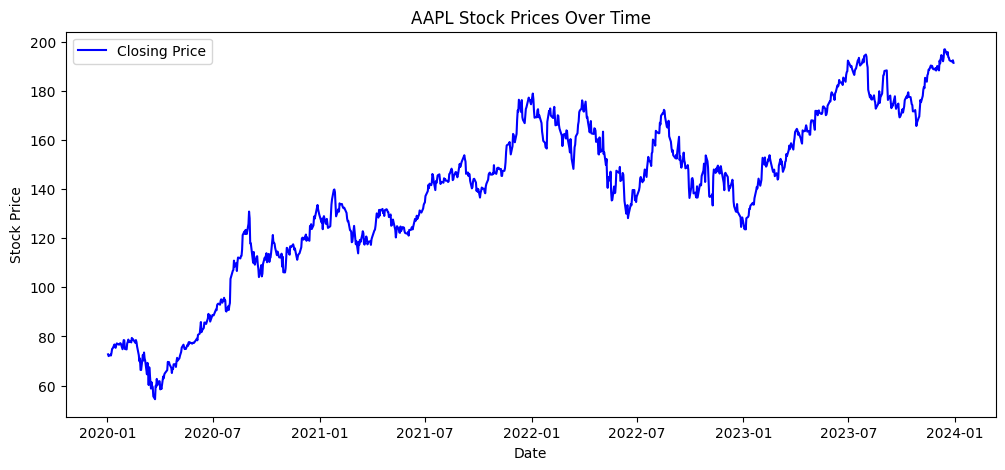

In [5]:
# stock price vs date
plt.figure(figsize=(12, 5))
plt.plot(data.index, prices, label="Closing Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"{ticker} Stock Prices Over Time")
plt.legend()
plt.show()

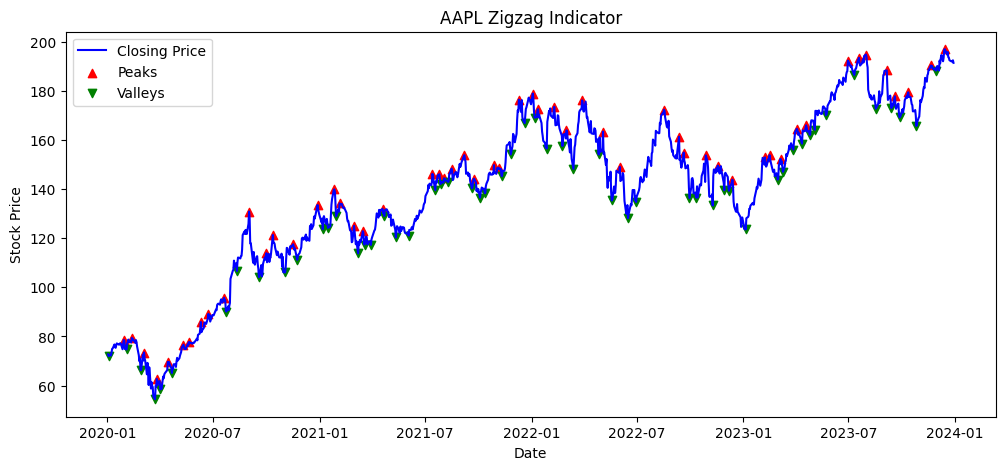

In [ ]:
# zig zag indicator to find trend changes (higher highs, higher lows, lower highs, lower lows)
def zigzag_indicator(prices, threshold=0.05):
    #identifies local maxima/minima as trend reversals.
    peaks = argrelextrema(prices, np.greater, order=5)[0]
    valleys = argrelextrema(prices, np.less, order=5)[0]
    return peaks, valleys

peaks, valleys = zigzag_indicator(prices)

plt.figure(figsize=(12, 5))
plt.plot(data.index, prices, label="Closing Price", color="blue")
plt.scatter(data.index[peaks], prices[peaks], color="red", label="Peaks", marker="^")
plt.scatter(data.index[valleys], prices[valleys], color="green", label="Valleys", marker="v")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"{ticker} Zigzag Indicator")
plt.legend()
plt.show()


In [ ]:
def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val), min_val, max_val

scaled_prices, min_price, max_price = min_max_scaling(prices)

In [25]:
split_ratio = 0.8
split_index = int(len(scaled_prices) * split_ratio)
train_data, test_data = scaled_prices[:split_index], scaled_prices[split_index:]

In [26]:
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Use past 10 days to predict next
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape for LSTM input (batch, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [50]:
class LSTM:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.001):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        
        # Initialize weights with Xavier initialization
        self.Wf = np.random.randn(hidden_dim, hidden_dim + input_dim) * np.sqrt(2 / (hidden_dim + input_dim))
        self.Wi = np.random.randn(hidden_dim, hidden_dim + input_dim) * np.sqrt(2 / (hidden_dim + input_dim))
        self.Wo = np.random.randn(hidden_dim, hidden_dim + input_dim) * np.sqrt(2 / (hidden_dim + input_dim))
        self.Wc = np.random.randn(hidden_dim, hidden_dim + input_dim) * np.sqrt(2 / (hidden_dim + input_dim))

        self.Wy = np.random.randn(output_dim, hidden_dim) * np.sqrt(2 / hidden_dim)
        
        self.bf = np.zeros((hidden_dim, 1))
        self.bi = np.zeros((hidden_dim, 1))
        self.bo = np.zeros((hidden_dim, 1))
        self.bc = np.zeros((hidden_dim, 1))
        self.by = np.zeros((output_dim, 1))
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def forward(self, x, h_prev, c_prev):
        concat = np.vstack((h_prev, x))  # shape = (hidden_dim + input_dim, 1)

        ft = self.sigmoid(np.dot(self.Wf, concat) + self.bf)
        it = self.sigmoid(np.dot(self.Wi, concat) + self.bi)
        c_tilde = self.tanh(np.dot(self.Wc, concat) + self.bc)
        c_next = ft * c_prev + it * c_tilde
        ot = self.sigmoid(np.dot(self.Wo, concat) + self.bo)
        h_next = ot * self.tanh(c_next)
        y_hat = np.dot(self.Wy, h_next) + self.by
        return y_hat, h_next, c_next

    
    def backward(self, X, y, h_prev, c_prev, y_pred, learning_rate=0.001):
        # Gradients calculation
        dWy = np.dot((y_pred - y), h_prev.T)
        dby = (y_pred - y)
        
        dh = np.dot(self.Wy.T, (y_pred - y))  # Backpropagate through Wy
        dc = dh * self.sigmoid(h_prev) * (1 - self.sigmoid(h_prev))  # Gradient through sigmoid activation
        
        return dWy, dby, dc, dh  # This will be used to update weights
    
    def train(self, X_train, y_train, epochs=10):
        for epoch in range(epochs):
            total_loss = 0
            h_prev = np.zeros((self.hidden_dim, 1))
            c_prev = np.zeros((self.hidden_dim, 1))

            for i in range(len(X_train)):
                x_seq = X_train[i].reshape(-1, 1)  # Fix: Reshape sequence properly
                y_true = y_train[i].reshape(self.output_dim, 1)  # Output reshape

                # Forward pass through all time steps
                for t in range(x_seq.shape[0]):
                    x_t = x_seq[t].reshape(self.input_dim, 1)  # Ensure correct shape
                    y_pred, h_prev, c_prev = self.forward(x_t, h_prev, c_prev)

                loss = np.mean((y_pred - y_true) ** 2)
                total_loss += loss

                # Backpropagation to update weights
                dWy, dby, dc, dh = self.backward(x_t, y_true, h_prev, c_prev, y_pred)
                self.Wy -= self.learning_rate * dWy
                self.by -= self.learning_rate * dby

            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.6f}")




    

In [54]:
lstm = LSTM(input_dim=1, hidden_dim=50, output_dim=1, learning_rate=0.001)
lstm.train(X_train, y_train, epochs=100)

Epoch 1/100, Loss: 104.536790
Epoch 2/100, Loss: 27.910667
Epoch 3/100, Loss: 18.619982
Epoch 4/100, Loss: 17.593954
Epoch 5/100, Loss: 17.184364
Epoch 6/100, Loss: 16.656913
Epoch 7/100, Loss: 16.049640
Epoch 8/100, Loss: 15.422295
Epoch 9/100, Loss: 14.803346
Epoch 10/100, Loss: 14.203749
Epoch 11/100, Loss: 13.627063
Epoch 12/100, Loss: 13.073975
Epoch 13/100, Loss: 12.544107
Epoch 14/100, Loss: 12.036703
Epoch 15/100, Loss: 11.550891
Epoch 16/100, Loss: 11.085783
Epoch 17/100, Loss: 10.640507
Epoch 18/100, Loss: 10.214220
Epoch 19/100, Loss: 9.806114
Epoch 20/100, Loss: 9.415412
Epoch 21/100, Loss: 9.041371
Epoch 22/100, Loss: 8.683279
Epoch 23/100, Loss: 8.340457
Epoch 24/100, Loss: 8.012251
Epoch 25/100, Loss: 7.698037
Epoch 26/100, Loss: 7.397218
Epoch 27/100, Loss: 7.109222
Epoch 28/100, Loss: 6.833501
Epoch 29/100, Loss: 6.569532
Epoch 30/100, Loss: 6.316811
Epoch 31/100, Loss: 6.074860
Epoch 32/100, Loss: 5.843219
Epoch 33/100, Loss: 5.621446
Epoch 34/100, Loss: 5.409122
Epoc

In [55]:
def predict(lstm, X_test):
    h_prev = np.zeros((lstm.hidden_dim, 1))
    c_prev = np.zeros((lstm.hidden_dim, 1))
    predictions = []
    
    for i in range(len(X_test)):
        x_seq = X_test[i].reshape(-1, 1)  # Shape = (seq_length, 1)
        
        # Use only the last timestep as input
        x_last = x_seq[-1].reshape(1, 1)  # Shape = (1, 1)
        
        y_pred, h_prev, c_prev = lstm.forward(x_last, h_prev, c_prev)  # Use last timestep
        
        predictions.append(y_pred.flatten()[0])
    
    return np.array(predictions)

# Predict on test set
y_pred_scaled = predict(lstm, X_test)

# Convert back to original scale
y_pred = y_pred_scaled * (max_price - min_price) + min_price
y_test_actual = y_test * (max_price - min_price) + min_price


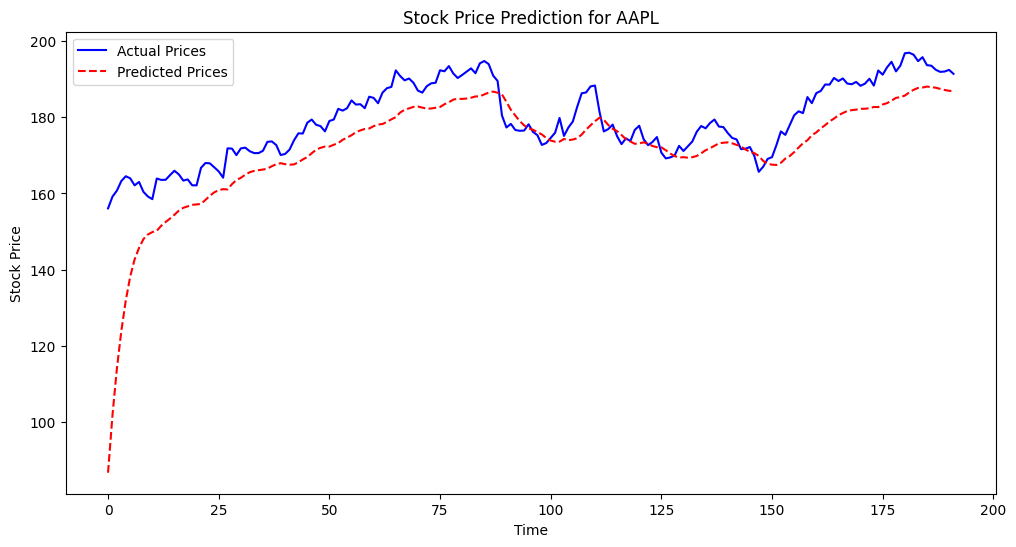

In [56]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Prices", color="blue")
plt.plot(y_pred, label="Predicted Prices", linestyle="dashed", color="red")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title(f"Stock Price Prediction for {ticker}")
plt.legend()
plt.show()

In [59]:
import pandas as pd

# Extract corresponding dates for test set
test_dates = data.index[split_index + seq_length:]  # Align with `y_test`

# Flatten the arrays to 1D
y_test_actual_flat = y_test_actual.flatten()
y_pred_flat = y_pred.flatten()

# Create DataFrame
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': y_test_actual_flat,
    'Predicted Price': y_pred_flat
})

# Display the table
print(results_df)


          Date  Actual Price  Predicted Price
0   2023-03-28    156.076004        86.709016
1   2023-03-29    159.164886       101.805597
2   2023-03-30    160.738998       114.061392
3   2023-03-31    163.253632       123.898292
4   2023-04-03    164.510925       131.888347
..         ...           ...              ...
187 2023-12-22    192.444595       187.743847
188 2023-12-26    191.897858       187.455980
189 2023-12-27    191.997253       187.150657
190 2023-12-28    192.424698       186.937003
191 2023-12-29    191.380966       186.854264

[192 rows x 3 columns]
